In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz

In [2]:
################################################## DATA PREPARATION #################################################################################### 
# --- Load your data ---
df = pd.read_csv("./data/winequality-red.csv", sep=';')

# Drop the target column
data = df.drop(columns=["quality"])

# Normalize data
zscore_scaler = StandardScaler()
zscor_data_pca = zscore_scaler.fit_transform(data)

# Convert back to DataFrame with original column names
zscor_data_pca = pd.DataFrame(zscor_data_pca, columns=data.columns)

# Optionally drop last column (if needed) -> last col is target
data_ap = zscor_data_pca.iloc[:, :-1]

# Convert to NumPy array for clustering
x = data_ap.values.astype(np.float32)

In [3]:
################################################## INITIALIZATION #################################################################################### 
# --- Preprocessing and APA initialization ---
nn, mm = x.shape
me, mmax, mmin, ranges = [], [], [], []
normalization = 0
threshold = 25
ancl = []

for j in range(mm):
    z = x[:, j]
    me.append(np.mean(z))
    mmax.append(np.max(z))
    mmin.append(np.min(z))
    ranges.append(1 if normalization else mmax[j] - mmin[j] or 1)

sy = np.divide((x - me), ranges)
sY = np.array(sy)
d = np.sum(sY * sY)

In [4]:
################################################## HELPER FUNCTIONS #################################################################################### 
def center_(x, cluster):
    return [np.mean(x[cluster, j]) for j in range(x.shape[1])]

def distNorm(x ,remains, ranges, p):
    z = x[remains, :]
    az = np.tile(p, (len(remains), 1))
    rz = np.tile(ranges, (len(remains), 1))
    dz = (z - az) / rz
    return np.sum(dz * dz, axis=1)

def separCluster(x, remains, ranges, a, b):
    dista = distNorm(x, remains, ranges, a)
    distb = distNorm(x, remains, ranges, b)
    return [remains[i] for i in np.where(dista < distb)[0]]

def anomalousPattern(x, remains, ranges, centroid, me):
    while True:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if not cluster:
            break
        newcenter = center_(x, cluster)
        if np.allclose(centroid, newcenter):
            break
        centroid = newcenter
    return cluster, centroid

def dist(x, remains, ranges, p):
    return np.sum(((x[remains] - p) / ranges) ** 2, axis=1)

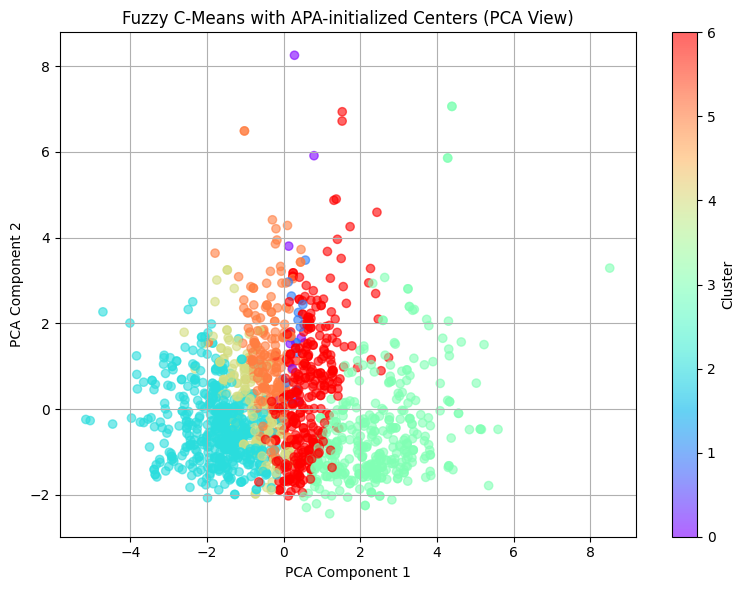

In [ ]:

# --- Run APA to get centroids ---
remains = list(range(nn))
numberC = 0
while remains:
    index = remains[np.argmax(dist(x, remains, ranges, me))]
    centroid = x[index, :]
    numberC += 1
    cluster, centroid = anomalousPattern(x, remains, ranges, centroid, me)
    censtand = np.divide((np.asarray(centroid) - me), ranges)
    dD = np.sum(censtand ** 2) * len(cluster) * 100 / d
    remains = list(set(remains) - set(cluster))
    #ancl.extend([cluster, censtand, dD])
    ancl.append((cluster, censtand, dD))


#ancl = np.array(ancl).reshape((numberC, 3), order='C')
cent = []
for cluster, censtand, dD in ancl:
    if len(cluster) >= threshold:
        cent.append(censtand)


# --- Extract valid centroids ---
#cent = []
#for ik in range(numberC):
 #   if len(ancl[ik, 0]) >= threshold:
  #      cent.append(ancl[ik, 1])
cent = []
for cluster, censtand, dD in ancl:
    if len(cluster) >= threshold:
        cent.append(censtand)


cent = np.array(cent).astype(np.float32)
n_clusters = len(cent)

# --- FCM with APA-initialized centers ---
data_for_fcm = x.T  # shape: (features, samples)

# Run FCM
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data=data_for_fcm,
    c=n_clusters,
    m=2,
    error=0.005,
    maxiter=1000,
    #init=cent, #AFTER RESEARCH, UPDATE THIS VALUE
    seed=42
)

# Labels and visualization
fuzzy_labels = np.argmax(u, axis=0)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(x)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=fuzzy_labels, cmap='rainbow', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title("Fuzzy C-Means with APA-initialized Centers (PCA View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
